# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [422]:
import pandas as pd
from scapy.all import rdpcap, DNS, IP, DNSRR

In [423]:
packets = rdpcap("netflix.pcap")

### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [424]:
dns_qrows = []

for pkt in packets:
    if not pkt.haslayer(DNS):
        continue

    # Here we want queries = 0
    if pkt[DNS].qr != 0:
        continue

    qname = pkt[DNS].qd.qname

    if IP in pkt:
        src_ip = pkt[IP].src
        dst_ip = pkt[IP].dst

    txn_id = hex(pkt[DNS].id)

    dns_qrows.append({
        "Time": pkt.time,
        "Source": src_ip,
        "Destination": dst_ip,
        "Length": len(pkt),
        "Transaction ID": txn_id,
        "Query": qname.decode()
    })

dns_queries = pd.DataFrame(dns_qrows)
dns_queries.head()


,Time,Source,Destination,Length,Transaction ID,Query
0,1518358200.534682,192.168.43.72,128.93.77.234,77,0xed0c,fonts.gstatic.com.
1,1518358200.534832,192.168.43.72,128.93.77.234,77,0x301a,fonts.gstatic.com.
2,1518358200.539408,192.168.43.72,128.93.77.234,87,0x11d3,googleads.g.doubleclick.net.
3,1518358200.541204,192.168.43.72,128.93.77.234,87,0x1284,googleads.g.doubleclick.net.
4,1518358200.545785,192.168.43.72,128.93.77.234,78,0x3432,ytimg.l.google.com.


In [425]:
NF_DOMAINS = ["nflxvideo", "netflix", "nflxso", "nflxext"]
pattern = "|".join(NF_DOMAINS)

nf_queries = dns_queries[dns_queries["Query"].str.contains(pattern)]
nf_queries.head()

,Time,Source,Destination,Length,Transaction ID,Query
12,1518358202.362996,192.168.43.72,128.93.77.234,75,0xb19a,www.netflix.com.
13,1518358202.363168,192.168.43.72,128.93.77.234,78,0x3049,assets.nflxext.com.
14,1518358202.363441,192.168.43.72,128.93.77.234,77,0x5f60,codex.nflxext.com.
15,1518358202.363675,192.168.43.72,128.93.77.234,86,0x1f03,customerevents.netflix.com.
16,1518358202.363921,192.168.43.72,128.93.77.234,99,0x7776,ipv4-c001-cdg001-ix.1.oca.nflxvideo.net.


In [426]:
txids = set(nf_queries["Transaction ID"])
txids

{'0x1f03',
 '0x269f',
 '0x3049',
 '0x37e9',
 '0x3981',
 '0x5542',
 '0x5f60',
 '0x6677',
 '0x7776',
 '0x80e9',
 '0x82dc',
 '0x86ee',
 '0x9415',
 '0xa9b1',
 '0xb19a',
 '0xc0b4',
 '0xed3f'}

In [427]:
ips = set()
# I used this source: https://stackoverflow.com/questions/42052956/how-to-read-scapys-dns-response-to-get-the-resolved-domains-ip-address
for pkt in packets:
    if not pkt.haslayer(DNS):
        continue
    
    # Here we want responses = 1
    if pkt[DNS].qr != 1:
        continue
    
    if hex(pkt[DNS].id) not in txids:
        continue

    for i in range(pkt[DNS].ancount):
        rdata = pkt[DNSRR][i].rdata
        ips.add(rdata)

ips = list(ips)
ips

['198.38.120.134',
 '198.38.120.164',
 '198.38.120.167',
 '198.38.120.153',
 '198.38.120.166',
 '34.252.77.54',
 '52.19.39.146',
 '198.38.120.162',
 '52.48.148.78',
 '23.57.80.120',
 '52.210.133.255',
 '198.38.120.130',
 '52.48.8.150',
 '52.208.128.101',
 '52.210.19.176',
 '198.38.120.137']

### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [428]:
rows = []
for pkt in packets:
    if IP in pkt:
        src_ip = pkt[IP].src
        dst_ip = pkt[IP].dst
    else:
        continue

    rows.append({
        "Time": pkt.time,
        "Source": src_ip,
        "Destination": dst_ip,
        "Length": len(pkt)
    })

ndf = pd.DataFrame(rows)
ndf.head()

,Time,Source,Destination,Length
0,1518358200.534682,192.168.43.72,128.93.77.234,77
1,1518358200.534832,192.168.43.72,128.93.77.234,77
2,1518358200.539408,192.168.43.72,128.93.77.234,87
3,1518358200.541204,192.168.43.72,128.93.77.234,87
4,1518358200.545785,192.168.43.72,128.93.77.234,78


In [429]:
# Downstream packets
nf_flows_d = ndf[ndf['Source'].isin(ips) | ndf['Source'].str.contains(pattern)].copy() # From the Performance service Hands on solutions
nf_flows_d["Time"] = nf_flows_d["Time"].astype(float)
downstream_bytes = nf_flows_d.groupby('Source').sum(numeric_only=True).reset_index()
downstream_bytes.head()

,Source,Time,Length
0,198.38.120.130,50105820887.185,4221
1,198.38.120.134,104766717624.337,12946
2,198.38.120.137,153354179816.951,17445
3,198.38.120.153,95656567116.630,8898
4,198.38.120.162,513205094831.257,62110


In [430]:
nf_flows_d = nf_flows_d.sort_values(["Source", "Time"])
nf_flows_d["IAT"] = nf_flows_d.groupby("Source")["Time"].diff()
iat_d = nf_flows_d[["Time", "IAT"]]
iat_d.head()

,Time,IAT
171,1518358203.617,NaN
174,1518358203.617,0.001
177,1518358203.619,0.001
283,1518358204.050,0.432
315,1518358204.682,0.632


In [431]:
# Upstream packets
nf_flows_u = ndf[ndf['Destination'].isin(ips) | ndf['Destination'].str.contains(pattern)].copy() # From the Performance service Hands on solutions
nf_flows_u["Time"] = nf_flows_u["Time"].astype(float)
upstream_bytes = nf_flows_u.groupby('Destination').sum(numeric_only=True).reset_index()
upstream_bytes.head()

,Destination,Time,Length
0,198.38.120.130,60734328359.729,3468
1,198.38.120.134,78954627822.048,3826
2,198.38.120.137,135133881151.473,6624
3,198.38.120.153,113876865626.570,6582
4,198.38.120.162,403883300356.358,18978


In [432]:
nf_flows_u = nf_flows_u.sort_values(["Destination", "Time"])
nf_flows_u["IAT"] = nf_flows_u.groupby("Destination")["Time"].diff()
iat_u = nf_flows_u[["Time", "IAT"]]
iat_u.head()

,Time,IAT
107,1518358202.903,NaN
109,1518358202.903,0.000
110,1518358202.903,0.000
148,1518358203.122,0.218
172,1518358203.617,0.495


In [433]:
window = 1 # 1 second bins
nf_flows_d["bins"] = ((nf_flows_d["Time"] - nf_flows_d["Time"].min())//window).astype(int)
download_rate = nf_flows_d.groupby("bins")["Length"].sum()
download_rate = download_rate.reset_index(name="bytes_downloaded")
download_rate.head()

,bins,bytes_downloaded
0,0,2220
1,1,7556
2,2,9524
3,3,3605
4,4,13322


In [434]:
nf_flows_u["bins"] = ((nf_flows_u["Time"] - nf_flows_u["Time"].min())//window).astype(int)
upload_rate = nf_flows_u.groupby("bins")["Length"].sum()
upload_rate = upload_rate.reset_index(name="bytes_uploaded")
upload_rate.head()

,bins,bytes_uploaded
0,0,10192
1,1,1614
2,2,5948
3,3,5108
4,4,4032


**Write a brief justification for the features that you have chosen.**

I chose to create 3 features for this warm-up:
Directly relavent features:
1) Inter-arrival times
 - For higher quality playback (with strong connection) we would expect shorter IATs. Long IATs could imply paused playback while buffering, etc.
2) Downloaded bytes per 1 second interval
 - For higher resolution video, we would expect larger values for this feature since more information is being obtained
3) Uploaded bytes per 1 second interval
 - Can give us insight on the frequency of requests to the servers for new segments, etc.

Features that could still be useful but are not directly relavent:
4) Downstream packets (aggregated by IP)
 - There may be implicit correlation between servers that have low number of packets and worse video quality.
 - Perhaps the the client prefers downloading from servers that have a stronger connection (higher bitrate for downloads) and so getting data from a
 - particular server can be indicative of the quality in that regard (implicitly gives us connection information for each endpoint)
5) Upstream packets (aggregated by IP)
 - Similar to the previous, we get implicit information about the network and which servers are quickest.

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [435]:
nf_flows_d = nf_flows_d.sort_values("Time")

In [436]:
window = 1 # 1 second bins
nf_flows_d["bins"] = ((nf_flows_d["Time"] - nf_flows_d["Time"].min())//window).astype(int)
nf_flows_d.head()

,Time,Source,Destination,Length,IAT,bins
171,1518358203.617,198.38.120.130,192.168.43.72,74,NaN,0
174,1518358203.617,198.38.120.130,192.168.43.72,74,0.001,0
177,1518358203.619,198.38.120.130,192.168.43.72,74,0.001,0
180,1518358203.620,198.38.120.153,192.168.43.72,74,NaN,0
183,1518358203.622,198.38.120.153,192.168.43.72,74,0.002,0


In [437]:
seg_rate = nf_flows_d.groupby("bins").size().reset_index(name='segment_downloads')
seg_rate.head()

,bins,segment_downloads
0,0,30
1,1,46
2,2,63
3,3,32
4,4,81


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [438]:
import pickle
with open("netflix_dataset.pkl", 'rb') as f:
    nflx_dtst = pickle.load(f)

### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [439]:
accepted = [240, 360, 480, 720, 1080]
nflx_dtst = nflx_dtst[nflx_dtst["resolution"].isin(accepted)]
nflx_dtst.head()

,10_EWMA_chunksizes,10_avg_chunksize,10_chunksizes_50,10_chunksizes_50R,10_chunksizes_75,10_chunksizes_75R,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,10_chunksizes_90R,10_max_chunksize,10_min_chunksize,10_std_chunksize,absolute_timestamp,access_50_perc,access_75_perc,access_avg,access_max,access_min,access_stddev,access_var,ads,all_prev_down_chunk_iat_50,all_prev_down_chunk_iat_50R,all_prev_down_chunk_iat_75,all_prev_down_chunk_iat_75R,all_prev_down_chunk_iat_85,all_prev_down_chunk_iat_85R,all_prev_down_chunk_iat_90,all_prev_down_chunk_iat_90R,all_prev_down_chunk_iat_avg,all_prev_down_chunk_iat_max,all_prev_down_chunk_iat_min,all_prev_down_chunk_iat_std,all_prev_up_chunk_iat_50,all_prev_up_chunk_iat_50R,all_prev_up_chunk_iat_75,all_prev_up_chunk_iat_75R,all_prev_up_chunk_iat_85,all_prev_up_chunk_iat_85R,all_prev_up_chunk_iat_90,all_prev_up_chunk_iat_90R,all_prev_up_chunk_iat_avg,all_prev_up_chunk_iat_max,all_prev_up_chunk_iat_min,all_prev_up_chunk_iat_std,allprev_avg_chunksize,allprev_chunksizes_50,allprev_chunksizes_50R,allprev_chunksizes_75,allprev_chunksizes_75R,allprev_chunksizes_85,allprev_chunksizes_85R,allprev_chunksizes_90,allprev_chunksizes_90R,allprev_max_chunksize,allprev_min_chunksize,allprev_std_chunksize,avg_flow_age,bitrate,bitrate_change,c_bitrate_switches,c_rebufferings,c_resolution_switches,chunk_end_time,chunk_start_time,cumsum_chunksizes,cumsum_diff,curr_chunksize,current_chunk_iat,deployment_session_id,down_chunk_iat_50,down_chunk_iat_50R,down_chunk_iat_75,down_chunk_iat_75R,down_chunk_iat_85,down_chunk_iat_85R,down_chunk_iat_90,down_chunk_iat_90R,down_chunk_iat_avg,down_chunk_iat_max,down_chunk_iat_min,down_chunk_iat_std,home_id,index,is_tcp,n_bitrate_switches,n_chunks_down,n_chunks_up,n_prev_down_chunk,n_prev_up_chunk,n_rebufferings,parallel_flows,previous_bitrate,quality,relative_timestamp,resolution,service_Video_throughput_down,service_Video_throughput_up,service_non_video_throughput_down,service_non_video_throughput_up,session_id,size_diff_previous,startup_time,total_throughput_down,total_throughput_up,up_chunk_iat_50,up_chunk_iat_50R,up_chunk_iat_75,up_chunk_iat_75R,up_chunk_iat_85,up_chunk_iat_85R,up_chunk_iat_90,up_chunk_iat_90R,up_chunk_iat_avg,up_chunk_iat_max,up_chunk_iat_min,up_chunk_iat_std,up_down_ratio,video_duration,video_id,video_position,wireless_50_perc,wireless_75_perc,wireless_avg,wireless_max,wireless_min,wireless_stddev,wireless_var,serverAckFlags,serverAvgBytesInFlight,serverAvgBytesPerPacket,serverAvgInterArrivalTime,serverAvgRetransmit,serverAvgRwnd,serverBitrateChange,serverByteCount,serverEndBytesPerPacket,serverFinFlags,serverGoodput,serverIdleTime,serverKurBytesInFlight,serverKurBytesPerPacket,serverKurInterArrivalTime,serverKurRetransmit,serverKurRwnd,serverMaxBytesInFlight,serverMaxBytesPerPacket,serverMaxInterArrivalTime,serverMaxRetransmit,serverMaxRwnd,serverMedBytesInFlight,serverMedBytesPerPacket,serverMedInterArrivalTime,serverMedRetransmit,serverMedRwnd,serverMinBytesInFlight,serverMinBytesPerPacket,serverMinInterArrivalTime,serverMinRetransmit,serverMinRwnd,serverOneRetransmit,serverOutOfOrderBytes,serverOutOfOrderPackets,serverPacketCount,serverPshFlags,serverRstFlags,serverSkeBytesInFlight,serverSkeBytesPerPacket,serverSkeInterArrivalTime,serverSkeRetransmit,serverSkeRwnd,serverStdBytesInFlight,serverStdBytesPerPacket,serverStdInterArrivalTime,serverStdRetransmit,serverStdRwnd,serverStrBytesPerPacket,serverSynFlags,serverThroughput,serverTwoRetransmit,serverUrgFlags,serverXRetransmit,serverZeroRetransmit,userAckFlags,userAvgBytesInFlight,userAvgBytesPerPacket,userAvgInterArrivalTime,userAvgRTT,userAvgRetransmit,userAvgRwnd,userByteCount,userEndBytesInFlight,userFinFlags,userGoodput,userIdleTime,userKurBytesInFlight,userKurBytesPerPacket,userKurInterArrivalTime,userKurRTT,userKurRetransmit,userKurRwnd,userMaxBytesInFlight,userMaxBytesPerPacket,userMaxInterArrivalTime,userMaxRTT,userMaxRetransmit,userMaxRwnd,userMedBytesInFlight,userMedBytesPerPacket,userMe

2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [440]:
import numpy as np

base_keep = [
    "bitrate", "bitrate_change", "previous_bitrate",
    "resolution",
    "c_bitrate_switches", "n_bitrate_switches", "c_resolution_switches",
    "c_rebufferings", "n_rebufferings",
    "curr_chunksize",
    "10_EWMA_chunksizes", "10_avg_chunksize", "10_std_chunksize", "10_min_chunksize", "10_max_chunksize",
    "down_chunk_iat_avg", "down_chunk_iat_std", "down_chunk_iat_min", "down_chunk_iat_max",
    "service_Video_throughput_down", "service_Video_throughput_up",
    "service_non_video_throughput_down", "service_non_video_throughput_up",
    "total_throughput_down", "total_throughput_up",
    "serverThroughput", "userThroughput", "serverGoodput", "userGoodput",
    "userAvgRTT", "userMedRTT", "userStdRTT",
    "serverAvgRetransmit", "userAvgRetransmit",
    "n_chunks_down", "n_prev_down_chunk", "parallel_flows",
    "access_avg", "wireless_avg",
    "up_down_ratio",
    "video_duration", "video_position"
]

# Used AI to write this helper that detects whether a column has sequence-like data
def column_has_sequences(s: pd.Series) -> bool:
    def is_sequence(x):
        if x is None or (isinstance(x, float) and pd.isna(x)):
            return False
        if isinstance(x, str):
            return False
        return isinstance(x, (np.ndarray, list, tuple, dict, set))
    sample = s.head(100)
    if sample.apply(is_sequence).any():
        return True
    return s.apply(is_sequence).any()

present_keep = [c for c in base_keep if c in nflx_dtst.columns]

# Drop sequence-like columns
seq_cols = []
for c in present_keep:
    if column_has_sequences(nflx_dtst[c]):
        seq_cols.append(c)

final_keep = [c for c in present_keep if c not in seq_cols]

nflx_dtst = nflx_dtst[final_keep].copy()
nflx_dtst


,bitrate,bitrate_change,previous_bitrate,resolution,c_bitrate_switches,n_bitrate_switches,c_resolution_switches,c_rebufferings,n_rebufferings,curr_chunksize,10_avg_chunksize,10_std_chunksize,10_min_chunksize,10_max_chunksize,down_chunk_iat_avg,down_chunk_iat_std,down_chunk_iat_min,down_chunk_iat_max,service_Video_throughput_down,service_Video_throughput_up,service_non_video_throughput_down,service_non_video_throughput_up,total_throughput_down,total_throughput_up,serverThroughput,userThroughput,serverGoodput,userGoodput,userAvgRTT,userMedRTT,userStdRTT,serverAvgRetransmit,userAvgRetransmit,n_chunks_down,n_prev_down_chunk,parallel_flows,access_avg,wireless_avg,up_down_ratio,video_duration,video_position
208,582.000,0.000,0,360.000,1,3,0,0,0,0,148947.100,185126.042,4380,539882,808.400,1223.071,34,3318,1486.592,56.521,0.016,0.000,1612.879,57.181,0.000,0.000,0.000,0.000,66511.024,73338.135,19684.625,0.000,21.680,11,10,4,0.000,0.000,1,600.000,10.000
209,865.000,283.000,0,360.000,1,2,0,0,0,0,91984.200,62449.107,24498,196778,478.800,377.706,19,1830,1808.675,35.790,0.008,0.000,3314.766,36.385,0.000,0.000,0.000,0.000,80963.257,84187.622,8183.942,0.000,26.571,20,30,5,0.000,0.000,2,600.000,20.000
210,865.000,0.000,0,360.000,0,0,0,0,0,0,147725.000,134268.560,24498,396800,553.000,552.959,64,2021,1863.401,8.774,0.000,0.000,1863.401,8.774,0.000,0.000,0.000,0.000,77564.132,78915.039,7087.849,0.000,32.652,19,49,5,0.000,0.000,2,600.000,30.000
211,865.000,0.000,0,360.000,1,2,0,0,0,0,246420.600,127394.372,24498,396800,1173.750,889.680,404,3062,1759.688,4.418,0.000,0.000,1759.688,4.421,0.000,0.000,0.000,0.000,122071.181,90416.748,56963.446,0.000,47.867,8,57,6,0.000,0.000,2,600.000,40.000
212,1366.000,501.000,0,480.000,1,2,1,0,0,0,336681.000,79844.368,198238,438000,1720.200,960.196,576,3435,1746.917,4.139,0.000,0.000,1747.094,4.266,0.000,0.000,0.000,0.000,75810.156,78106.201,10988.579,0.000,71.333,5,62,6,0.000,0.000,2,600.000,50.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200633,1366.000,0.000,0,480.000,0,0,0,0,0,0,498288.400,160432.202,195176,690392,2685.000,1732.121,236,3956,1393.588,1.927,0.000,0.000,1397.000,2.888,0.000,0.000,0.000,0.000,5914.551,5914.551,1467.529,0.000,185.333,3,260,2,0.000,0.000,0,603.000,560.000
200634,1366.000,0.000,0,480.000,0,0,0,0,0,0,495682.800,159878.852,195176,690392,2745.000,1785.618,220,4038,1125.987,1.691,0.000,0.000,1129.528,2.731,0.000,0.000,0.000,0.000,15562.073,7221.802,17117.669,0.000,113.667,3,263,2,0.000,0.000,1,603.000,570.000
200635,1366.000,0.000,0,480.000,0,0,0,0,0,0,558961.000,232997.112,195176,1020538,4051.333,163.569,3821,4185,1798.597,1.595,0.000,0.000,1807.631,5.733,0.000,0.000,0.000,0.000,7549.072,7549.072,221.924,0.000,240.667,3,266,2,0.000,0.000,0,603.000,580.000
200636,1366.000,0.000,0,480.000,0,0,0,0,0,0,599166.800,259358.016,195172,1020538,2646.667,1616.922,375,4009,1472.766,1.593,0.000,0.000,1475.954,2.573,0.000,0.000,0.000,0.000,12129.883,6583.618,12369.431,0.000,145.167,3,269,2,0.000,0.000,1,603.000,590.000


**Briefly explain why you removed those columns.**

The most important thing that I tired to enforce was the removal of sequence-like features. Given that the model I use expects numeric values,
these features would result in errors or would have to be mapped to some numeric equivalent. This mapping may not be possible if the 
data do not have a neat finite sample space. To avoid all these cases, I simply chose to get rid of them.

From looking through the features in the dataset, I constructed a preliminary list of features that I believed to be numeric and relavent.
I made sure not to inlucde features that could lead to model overfitting like user metadata, or session metadata or other features unrelated to the 
actual quality of the video. This includes fields like session ID, video id, ads, most of the user... features (like "userIdleTime"), most of the server... features,
amongst others.

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [441]:
from sklearn.model_selection import train_test_split

X = nflx_dtst.drop(columns=["resolution"])
y = nflx_dtst["resolution"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [442]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

clf = RandomForestClassifier(n_estimators=50)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [443]:
vals = [10, 20, 50, 100, 200]
for e in vals:    
    t_clf = RandomForestClassifier(n_estimators=e)
    t_clf.fit(X_train, y_train)
    y_pred = t_clf.predict(X_test)
    print(f"Estimators = {e}; Accuracy: {accuracy_score(y_test, y_pred)}; F1-score: {f1_score(y_test, y_pred, average='weighted')}")


Estimators = 10; Accuracy: 0.8971859296482412; F1-score: 0.8946718782536922
Estimators = 20; Accuracy: 0.9061306532663317; F1-score: 0.9033943409835825
Estimators = 50; Accuracy: 0.9097487437185929; F1-score: 0.9066882682201024
Estimators = 100; Accuracy: 0.9093467336683417; F1-score: 0.90603764939479
Estimators = 200; Accuracy: 0.9111557788944724; F1-score: 0.907781406359124


Observe that Estimators=50 is a good balance of performance and runtime, so this is the parameter I will use

### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

In [444]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-Score", f1_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9096482412060302
F1-Score 0.9062587356917696
Confusion Matrix:
 [[ 164   37  105   35    0]
 [  24  670  183    7    0]
 [  30   65 5767   85    4]
 [   4    5  245 1549   44]
 [   0    1   12   13  901]]


Macro AUC: 0.9829081696242623


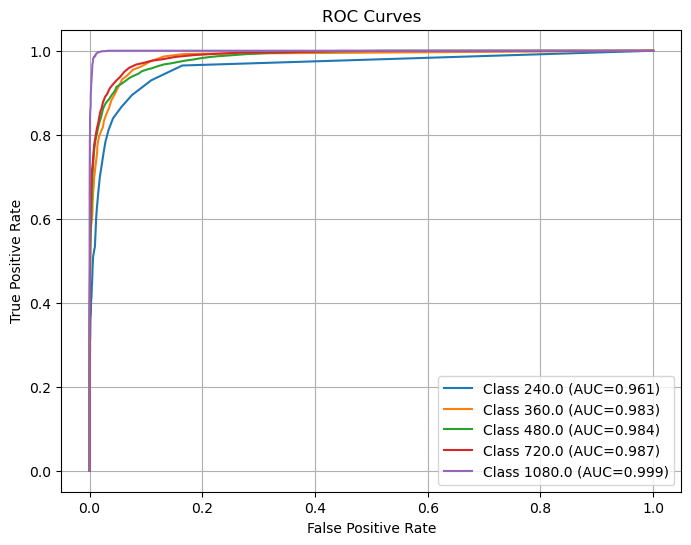

In [445]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_prob = clf.predict_proba(X_test)

auc = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
print("Macro AUC:", auc)

plt.figure(figsize=(8,6))

# Inspired by Chase's comment on the slack channel
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC={round(roc_auc_score(y_test_bin[:, i], y_prob[:, i]), 3)})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.show()


## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

In [446]:
y_pred = clf.predict(X_test)

# Assuming each row is 10 seconds apart from slack message
timeline = np.arange(len(y_pred))*10

df_pred = pd.DataFrame({"time": timeline,"predicted_resolution": y_pred,"true_resolution": y_test.values})
df_pred.head()


,time,predicted_resolution,true_resolution
0,0,480.000,480.000
1,10,720.000,720.000
2,20,360.000,360.000
3,30,480.000,480.000
4,40,360.000,360.000


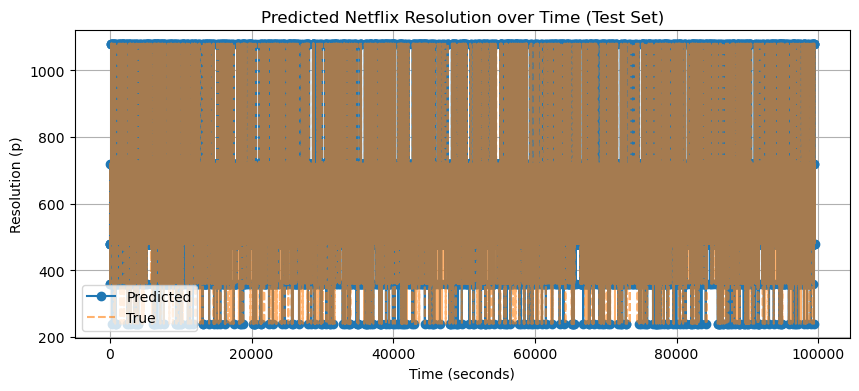

In [447]:
# Used AI to generate this plot code
plt.figure(figsize=(10,4))
plt.plot(df_pred["time"], df_pred["predicted_resolution"], marker="o", label="Predicted")
plt.plot(df_pred["time"], df_pred["true_resolution"], linestyle="--", label="True", alpha=0.6)
plt.title("Predicted Netflix Resolution over Time (Test Set)")
plt.xlabel("Time (seconds)")
plt.ylabel("Resolution (p)")
plt.legend()
plt.grid(True)
plt.show()


This graph is hard to make sense of so I zoomed into a smaller portion (100 samples)

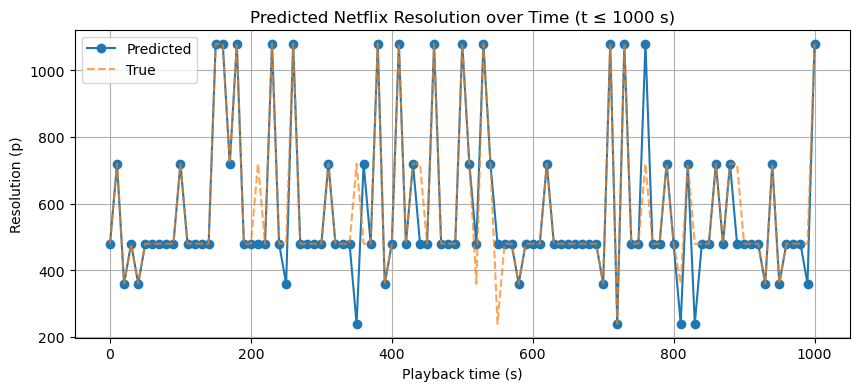

In [448]:
df_sub = df_pred[df_pred["time"] <= 1000]

# Used AI to generate this plot code
plt.figure(figsize=(10,4))
plt.plot(df_sub["time"], df_sub["predicted_resolution"], marker='o', label='Predicted')
plt.plot(df_sub["time"], df_sub["true_resolution"], linestyle='--', alpha=0.7, label='True')
plt.xlabel("Playback time (s)")
plt.ylabel("Resolution (p)")
plt.title("Predicted Netflix Resolution over Time (t ≤ 1000 s)")
plt.legend()
plt.grid(True)
plt.show()